In [1]:
import os
import scipy.io
import matplotlib.pyplot as plt
from scipy.special import expit
import numpy as np
import copy
import pandas as pd
import plotly.express as px
from sklearn.metrics import accuracy_score
np.random.seed(42)

# Utility Functions

In [2]:
def shuffleMe(data, labels):
    """Function shuffles the input array and returns a shuffled array"""
    indices = np.random.permutation(len(data))
    shuffled_data = data[indices]
    shuffled_labels = labels[indices]
    return shuffled_data, shuffled_labels
def resultsToCsv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1
    df.to_csv(f"/Users/christian/Desktop/CS189/Homeworks/hw4/wine_predictions.csv", index_label='Id')
def NormalizeData(X):
    # NORMALIZE THE ENTIRE TRAINING
    X_Normalized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    return X_Normalized

# PCA Class Definition

In [3]:
class PCA:
    def __init__(self, variance=0.80):
        self.data = None
        self.data_transformed = None
        self.variance = variance  # Proportion of variance to retain
        self.eigenvalues = None
        self.eigenvectors = None
        self.covariance_matrix = None

    def pca(self, data):
        self.data = data
        self.covariance_matrix = np.cov(self.data, rowvar=False)
        self.eigenvalues, self.eigenvectors = np.linalg.eig(self.covariance_matrix)
        idx = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[idx]
        self.eigenvectors = self.eigenvectors[:, idx]
        
        total_variance = np.sum(self.eigenvalues)
        variance_ratios = self.eigenvalues / total_variance
        cumulative_variance = np.cumsum(variance_ratios)
        num_components = np.where(cumulative_variance >= self.variance)[0][0] + 1
        
        self.data_transformed = self.data @ self.eigenvectors[:, :num_components]
        self.eigenvectors = self.eigenvectors[:, :num_components]


        # Print information
        print("Eigenvalues:", self.eigenvalues[:num_components])
        print("Number of components to retain:", num_components)
        print("Cumulative variance explained by these components:", cumulative_variance[num_components - 1])

        return self.data_transformed


# Wine Data Preprocessing

In [4]:
# Change working directory
os.chdir("/Users/christian/Documents/CS189/Homeworks/hw4")
os.getcwd()
os.listdir()


# load mat file
data = scipy.io.loadmat('data.mat')
# Extract training data from mat file
X_train = data['X']
# Extract and flatten the training labels in the mat file
y_train = data['y'].flatten()
# Extract true test data from mat file
X_test = data['X_test']

# Normalize entire dataset
X_train_normalized = NormalizeData(X_train)

# shuffle the entire dataset
X_train_norm_shuffled, y_train_shuffled = shuffleMe(X_train_normalized, y_train)

# Normalize true test data 
X_test_normalized_no_bias = (X_test - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)

#  80% of the data
_80 = int(len(X_train_norm_shuffled) * .80)

# Non PCA data
_X_train = X_train_norm_shuffled[:_80] 
_Y_train = y_train_shuffled[:_80]
_X_valid  = X_train_norm_shuffled[_80:]
_Y_valid = y_train_shuffled[_80:]


# Logistic Regression Class For Data With No Bias Term

In [5]:
class LogisticRegression():
    def __init__(self):
        # shuffle the normalized training data and labels
        self.X = None
        self.Y = None
        self.X_valid = None
        self.Y_valid = None
        self.epsilon = None
        self.Lambda = None
        self.weights = None
        self.batch_optimal_w = None
        self.stochastic_optimal_w = None
        self.mincost = None
        self.stochastic_cost = None
        self.topAccuracy = None
    # setter functions
    def setX(self, X):
        self.X = X
    def setY(self, Y):
        self.Y = Y
    def setXValid(self, X_valid):
         self.X_valid = X_valid
    def setYValid(self, Y_valid):
        self.Y_valid = Y_valid
    def setWeights(self):
        """Sets weight vectors (no bias term)"""
        self.weights = np.zeros(self.X.shape[1])
    # getter functions
    def getWeights(self):
        return self.weights
    def getXValid(self):
        return self.X_valid
    def getXTrain(self):
        return self.X
    def getValidationLabels(self):
        return self.Y_valid
    def batchGradientDescent(self):
        s = expit(self.X @ self.weights)
        gradient = (self.X.T @ (self.Y - s)) + (self.Lambda * self.weights)
        # Im pretty sure the gradient is negative which is why i use a plus sign
        return (self.weights + (self.epsilon * gradient))
    def LogisticRegressionCost(self):
        predictions = expit(self.X @ self.weights)
        # Clip predictions to avoid log(0)
        predictions_clipped = np.clip(predictions, self.epsilon, 1 - self.epsilon)
        return -np.mean(self.Y * np.log(predictions_clipped) + (1 - self.Y) * np.log(1 - predictions_clipped))
    def getAccuracy(self):
        """Returns the accuracy on the validation set"""
        threshold = 0.5
        predictions = expit(self.X_valid @ self.weights)
        predictionClipped = np.clip(predictions, self.epsilon, 1 - self.epsilon)
        # Convert probabilities to binary class labels
        y_hat  = (predictionClipped >= threshold).astype(int)
        accuracy = accuracy_score(self.Y_valid, y_hat)
        return accuracy
    def StochasticGradientDescent(self, i):
        """Returns optimal w by training on every point (stochastic gradient descent)"""
        s = expit(self.X[i] @ self.weights)
        new_w =  self.weights + (1e-3 * ((self.Y[i] - s) * self.X[i] + (1/4 * self.weights)))
        return new_w
    def fit(self, X, Y, X_valid, Y_valid, epsilon, lam):
        """
        Code for Kaggle Predictions
        Takes training and validation data in PCA form with no bias term. 
        Finds an optimal weight vector that optimizes accuracy on the validation set in PCA form. 

        Parameters:
        X (np.array): Input training Data (in this case with no bias term because it's in PCA).
        Y (np.array): Input labels for training data.
        X_valid (np.array) : Input validation data.
        Y_valid (np.array) : Input valudation data labels.
        """
        self.epsilon = epsilon
        self.Lambda = lam
        self.setX(X)
        self.setY(Y)
        self.setXValid(X_valid)
        self.setYValid(Y_valid)
        self.setWeights() 
        self.mincost= -1
        
        cost = - 1
        topAcc = self.getAccuracy()
        #print('dot product of features and training labels')
        #print(trainingFeatures.T @ trainingLabels)
        for i in range(100_000):
            self.weights = self.batchGradientDescent()
            cost = self.LogisticRegressionCost()
            acc = self.getAccuracy() 
            if acc > topAcc:
                topAcc = acc
                self.topAccuracy = acc
                self.optimalW = self.weights
                self.mincost = cost
    
    def predict(self, data):
        """Makes predictions on training, test, validation normalized test/validation sets"""
        #np.hstack([np.ones((data.shape[0], 1)), data])
        predictions = expit(data @ self.optimalW)
        predictionsClipped = np.clip(predictions, self.epsilon, 1 - self.epsilon)
        y_hat = (predictionsClipped >= 0.5).astype(int)
        return y_hat


# 3.2

In [6]:

"""
Performs Batch Gradient Descent Across Different Ranges to find optimal W with lowest cost using the same epsilon and lambda value
Makes predictions to kaggle using optimal w found
    """
sizes = [10, 100, 1000, 3000, 4000]
    
# add bias term to data
x_train_with_bias = np.hstack([np.ones((_X_train.shape[0], 1)), _X_train])
x_valid_with_bias = np.hstack([np.ones((_X_valid.shape[0], 1)), _X_valid])
    
logistic = LogisticRegression()
logistic.setX(x_train_with_bias)
logistic.setY(_Y_train)
logistic.setXValid(x_valid_with_bias)
logistic.setYValid(_Y_valid)
logistic.setWeights()
logistic.epsilon = 1e-1
logistic.Lambda = 1/3

currMinCost = logistic.LogisticRegressionCost()
optimalWeights = logistic.weights
overallCosts = []
costs = []
    
for n in sizes:
    costs = []
    for i in range(n):
        # Update weight vector
        # Calculate risk with new weight vector 
        cost = logistic.LogisticRegressionCost()
        logistic.weights = logistic.batchGradientDescent()
        # if the risk decreased save the risk value and the optimal weights vector
        if cost < currMinCost:
            currMinCost = cost
            logistic.batch_optimal_w = logistic.weights.copy()
            logistic.mincost = cost
            # append the risk after n iterations to list of costs
        costs.append(currMinCost)
    overallCosts.append(min(costs))
print("Optimal Weights: ")
print(logistic.batch_optimal_w)
print("Epsilon:", logistic.epsilon)
print("Lambda:", logistic.Lambda)
print("Minimum cost: ", round(logistic.mincost, 4))
    
fig = px.line(
    pd.DataFrame({"sizes" : sizes, "costs" : overallCosts}),
    x='sizes', 
    y='costs', 
    title='Size vs. Costs')
fig.update_layout(
    xaxis_title="Sizes",
    yaxis_title="Costs",
)
fig.show()

Optimal Weights: 
[-1.89597506e+16  7.06804131e+15  7.24205590e+15 -2.10660254e+15
 -6.16628254e+15  4.28861956e+15 -1.72776184e+15 -1.25235091e+16
  9.14238416e+15  4.04858685e+15  5.57527696e+15  1.06873600e+15
  4.29767784e+15]
Epsilon: 0.1
Lambda: 0.3333333333333333
Minimum cost:  0.1224


# 3.4 & 3.5 Stochastic Gradient Descent

In [7]:
#  Shuffle and split normalized non pca data with no bias term
data, labels = shuffleMe(X_train_normalized, y_train)

# split shuffled data into validation and training sets
stochastic_validation_data = data[_80:]
stochastic_validation_labels = labels[_80:]
stochastic_training_data = data[:_80]
stochastic_training_labels = labels[:_80]

# Declare logistic regression object
stochastic_logistic_regression = LogisticRegression()
stochastic_logistic_regression.setX(stochastic_training_data)
stochastic_logistic_regression.setY(stochastic_training_labels)
stochastic_logistic_regression.setXValid(stochastic_validation_data)
stochastic_logistic_regression.setYValid(stochastic_validation_labels)
stochastic_logistic_regression.setWeights()
stochastic_logistic_regression.epsilon = 1e-5
stochastic_logistic_regression.Lambda = 1/5

stochastic_logistic_regression.stochastic_cost = stochastic_logistic_regression.LogisticRegressionCost()

stochastic_costs = []
stochastic_accuracy = -1

for i in range(stochastic_logistic_regression.X.shape[0]):
    stochastic_logistic_regression.weights = stochastic_logistic_regression.StochasticGradientDescent(i)
    stochastic_logistic_regression.epsilon = stochastic_logistic_regression.epsilon
    temp_cost = stochastic_logistic_regression.LogisticRegressionCost()
    temp_accuracy = stochastic_logistic_regression.getAccuracy()

    if temp_accuracy > stochastic_accuracy:
        stochastic_accuracy = temp_accuracy

    if temp_cost < stochastic_logistic_regression.stochastic_cost:
        stochastic_logistic_regression.stochastic_cost = temp_cost
    
    stochastic_costs.append(temp_cost)
print("Minimum cost with stochastic gradient descent:", round(stochastic_logistic_regression.stochastic_cost, 4))


Minimum cost with stochastic gradient descent: 0.2417


In [8]:
t = range(4000)

fig_3_4 = px.scatter(pd.DataFrame({'Index' :t
                                   ,'Cost' : stochastic_costs})
                                   , x ='Index'
                                   , y = 'Cost'
                                   , title='Iterations vs. Cost in Stochastic Gradient Descent (e = e / t)')
fig_3_4.update_layout(
    xaxis_title = 'Training Point No.',
    yaxis_title = 'Cost'
)

fig_3_4.show()


# 3.6 Kaggle

## 1. Project data onto its principle components.

In [9]:
# Pca 
print('Training Data PCA')
training_pca = PCA()
x_training_pca = training_pca.pca(X_train_norm_shuffled)
print(x_training_pca.shape)
# pca on the true test set

# project test data onto training eigenvectors
x_test_pca = X_test_normalized_no_bias @ training_pca.eigenvectors

# entire training set in pca form
_x_train_PCA = x_training_pca[:_80]

_y_train_PCA = y_train_shuffled[:_80]
# Set aside 20% of data training data for validation"
_x_valid_PCA = x_training_pca[_80:]
_y_valid_PCA = y_train_shuffled[_80:]

Training Data PCA
Eigenvalues: [3.04572584 2.66938065 1.64025833 1.07611257 0.81868567 0.65864493]
Number of components to retain: 6
Cumulative variance explained by these components: 0.8255688529462284
(5000, 6)


## 2. Perform Logistic Regression With L2 Loss Regularization on PCA Transformed Data (No Bias Term)

In [10]:
logisticPCA = LogisticRegression()
# Model is fit with only 100_000 iterations
x_train_pca_with_bias = np.hstack([np.ones((_x_train_PCA.shape[0], 1)), _x_train_PCA])
x_valid_pca_with_bias = np.hstack([np.ones((_x_valid_PCA.shape[0], 1)), _x_valid_PCA])

logisticPCA.fit(x_train_pca_with_bias, _y_train_PCA, x_valid_pca_with_bias, _y_valid_PCA, epsilon= 1e-3, lam=1/9)

x_test_pca_with_bias = np.hstack([np.ones((x_test_pca.shape[0], 1)), x_test_pca])

logisticKagglePredictions = logisticPCA.predict(x_test_pca_with_bias)
resultsToCsv(logisticKagglePredictions)


OSError: Cannot save file into a non-existent directory: '/Users/christian/Desktop/CS189/Homeworks/hw4'

In [ ]:
print(pd.Series(logisticKagglePredictions).value_counts())
print('Accuracy on validation set: ', logisticPCA.getAccuracy())
print('Kaggle Score: .99')

0    738
1    262
dtype: int64
Accuracy on validation set:  0.985
Kaggle Score: .99


# 5.1

In [ ]:
def NormContourPlot(norm):
    # Define the grid
    x_range = np.linspace(0, 30, 5)
    y_range = np.linspace(0, 30, 5)
    X, Y = np.meshgrid(x_range, y_range)

    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = np.array([X[i, j], Y[i, j]])
            Z[i, j] = (sum(x**norm)**(1/norm))

    # Plot the contour plot
    contours = plt.contour(X, Y, Z, levels=5)
    plt.clabel(contours, inline=True, fontsize=10)
    plt.title('LP Norm Contour Plot')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.autoscale(enable=True, tight=True)
    plt.show()

In [ ]:
# Assume X_train is your training data
data_centered = X_train - np.mean(X_train, axis=0)

# Compute the covariance matrix
covariance_matrix = np.cov(data_centered, rowvar=False)

# Perform the SVD
U, S, Vt = np.linalg.svd(covariance_matrix)

# Create the D matrix which is the inverse square root of the eigenvalues matrix
D = np.diag(1.0 / np.sqrt(S))

# Whiten the data
data_whitened = data_centered @ U @ D @ Vt

In [ ]:
norms = [0.5, 1, 2]
lps = []

for p in norms:
    temp_w = np.ones(2)
    lps.append(sum(temp_w**p) ** (1/p))


print(lps)

[4.0, 2.0, 1.4142135623730951]


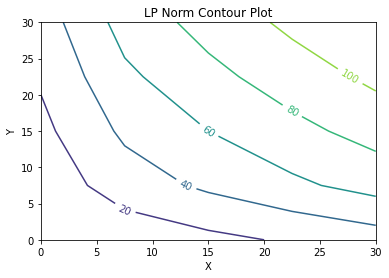

In [ ]:
NormContourPlot(norms[0])

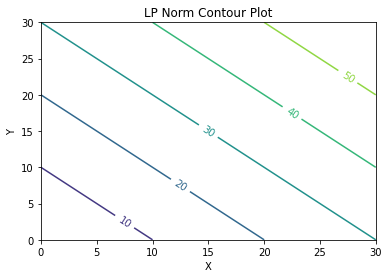

In [ ]:
NormContourPlot(norms[1])

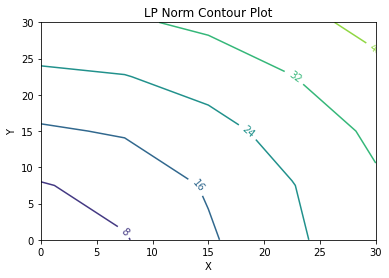

In [ ]:
NormContourPlot(norms[2])